In [11]:
# Game plan - Part 1 
# 1. 2-layer sequential search space - 20 architectures
#      a. at least 2 operations should allow for weight entanglement
#      b. Use a simple function/regression problem
# 2. Bi-level optimization for NAS from scratch
#      a. DARTS - First order, Second order without autograd
#      b. GDAS -  without autograd
#      c. DrNAS - without autograd
#      d. Check the grad cosine
# 3. Sampling based  one-shot
#      a. Apply spos on the search space
#      b. Use evolutionary search
# 4. One shot with WE
#     a. Repeat 2 with WE



## One shot optimizers on a simple search space and toy dataset - DARTS V1 and DARTS V2
1. Two layer sequential search space - (done)
2. Define the bi-level optimization scheme for DrNAS (pending-kl,wd ie l2), GDAS, DARTS -> first (done) and second order(darts-pending)
3. Exhaustively evaluate archs in the search space : 
    - Do we find the best one? (running)
    - What if we include higher order terms? (pending)
    - How do the optimizers compare? (running)

In [12]:
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torchvision.datasets as datasets
from torch.autograd import Variable
import torchvision
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [13]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.7,), (0.7,)),])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
train_size = int(0.5 * len(mnist_train))
val_size = len(mnist_train) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(mnist_train, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True)

In [14]:
from tiny_model import Net

alphas1
alphas2
Train acc 0.6785714285714286
Val acc 0.9207422707889126
Train acc 0.9375
Val acc 0.9496268656716418
Train acc 0.9557569296375267
Val acc 0.9560567697228145
Train acc 0.9635194562899787
Val acc 0.9630530383795309
Train acc 0.9676172707889126
Val acc 0.9623867270788913
Train acc 0.9690165245202559
Val acc 0.9612539978678039
Train acc 0.9720149253731343
Val acc 0.9687166844349681
Train acc 0.972647921108742
Val acc 0.9600546375266524
Train acc 0.9754464285714286
Val acc 0.9692830490405118
Train acc 0.9758128997867804
Val acc 0.96875
Train acc 0.9771122068230277
Val acc 0.9701492537313433
Train acc 0.9783781982942431
Val acc 0.9703491471215352
Train acc 0.9782116204690832
Val acc 0.9691497867803838
Train acc 0.9788113006396588
Val acc 0.9586553837953091
Train acc 0.9801772388059702
Val acc 0.9704490938166311
Train acc 0.9792777185501066
Val acc 0.972647921108742
Train acc 0.9812766524520256
Val acc 0.9723813965884861
Train acc 0.9806769722814499
Val acc 0.9742470682302772
T

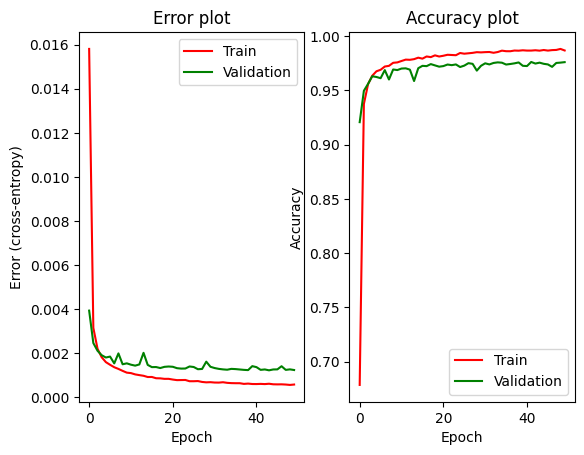

Test accuracy : 0.9776


In [15]:
param_list = []
model = Net(4,4,20,'darts').cuda()
for n,p in model.named_parameters():
    if "alpha" not in n:
        param_list.append(p)
    else:
        print(n)

optimizer = torch.optim.SGD(param_list,lr=0.1)
optimizer_arch = torch.optim.Adam([model.alphas1,model.alphas2],lr=0.001,weight_decay = 1e-3)
criterion = nn.CrossEntropyLoss()
batch_size = 64
train_errors = []
train_acc = []
val_errors = []
val_acc = []
n_train = len(train_loader)*batch_size
n_val = len(val_loader)*batch_size
tau = torch.Tensor([0.1])
for i in range(50):
  total_loss = 0
  total_acc = 0  
  c = 0
  for (images,labels), (images_val,labels_val) in zip(train_loader,val_loader):
    images = images.cuda()
    labels = labels.cuda()
    images_val = images_val.cuda()
    labels_val = labels_val.cuda()    
    optimizer.zero_grad()
    output = model(images,tau)
    loss = criterion(output,labels)
    loss.backward()
    optimizer.step()
    optimizer_arch.zero_grad()
    output_val = model(images_val,tau)
    loss_val = criterion(output_val,labels_val)
    loss_val.backward()
    optimizer_arch.step()    
    total_loss+=loss.item()
    total_acc+=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0    
    c+=1
    
  
  #validation
  
  total_loss_val = 0
  total_acc_val = 0
  c = 0
  for images,labels in val_loader:
    images = images.cuda()
    labels = labels.cuda()
    output = model(images,tau)
    loss = criterion(output,labels)
    
    total_loss_val +=loss.item()
    total_acc_val +=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0
    c+=1
  train_errors.append(total_loss/n_train)
  train_acc.append(total_acc/n_train)
  val_errors.append(total_loss_val/n_val)
  val_acc.append(total_acc_val/n_val)
  print("Train acc",train_acc[-1])
  print("Val acc",val_acc[-1])  
print("Training complete")

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(train_errors, 'r',label="Train")
ax[0].plot(val_errors, 'g', label="Validation")
ax[0].set_title("Error plot")
ax[0].set_ylabel("Error (cross-entropy)")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[1].plot(train_acc, 'r',label="Train")
ax[1].plot(val_acc, 'g', label="Validation")
ax[1].set_title("Accuracy plot")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].legend()
plt.show()

total_acc = 0
for images,labels in test_loader:
  images = images.cuda()
  labels = labels.cuda()
  output = model(images,tau)
  total_acc+=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0

print("Test accuracy :",total_acc/len(test_loader.dataset))

In [16]:
print(torch.argmax(torch.nn.functional.softmax(model.alphas1,dim=-1)))
print(torch.argmax(torch.nn.functional.softmax(model.alphas2,dim=-1)))

tensor(5, device='cuda:0')
tensor(2, device='cuda:0')


In [ ]:
# Game plan - Part 2 
# 1. Small cell-based search space 
#      a. at least 2 operations should allow for weight entanglement
#      b. Use a simple function/regression problem
# 2. Bi-level optimization for NAS from scratch
#      a. DARTS - First order, Second order without autograd
#      b. GDAS -  without autograd
#      c. DrNAS - without autograd
#      d. Check the grad cosine
# 3. Sampling based  one-shot
#      a. Apply spos on the search space
#      b. Use evolutionary search
# 4. One shot with WE
#     a. Repeat 2 with WE

In [ ]:
torch.nn.functional.softmax(model.alphas1,dim=-1)

In [17]:
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torchvision.datasets as datasets
from torch.autograd import Variable
import torchvision
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.7,), (0.7,)),])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
train_size = int(0.8 * len(mnist_train))
val_size = len(mnist_train) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(mnist_train, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True)


Train acc 0.40952083333333333
Val acc 0.4665890957446808
Train acc 0.5015
Val acc 0.5280086436170213
Train acc 0.5197708333333333
Val acc 0.5243517287234043
Train acc 0.5360625
Val acc 0.5332446808510638
Train acc 0.5500625
Val acc 0.558344414893617
Train acc 0.5568333333333333
Val acc 0.5683178191489362
Train acc 0.5684166666666667
Val acc 0.5772107712765957
Train acc 0.5753958333333333
Val acc 0.5807014627659575
Train acc 0.5829583333333334
Val acc 0.5868517287234043
Train acc 0.588625
Val acc 0.5999833776595744
Train acc 0.5967916666666667
Val acc 0.6084607712765957
Train acc 0.6043125
Val acc 0.6001496010638298
Train acc 0.6098541666666667
Val acc 0.6182679521276596
Train acc 0.6138333333333333
Val acc 0.6172706117021277
Train acc 0.6174375
Val acc 0.6225066489361702
Train acc 0.617
Val acc 0.6239195478723404
Train acc 0.62025
Val acc 0.617436835106383
Train acc 0.622375
Val acc 0.6282413563829787
Train acc 0.6198125
Val acc 0.6225897606382979
Train acc 0.6234791666666667
Val acc 0

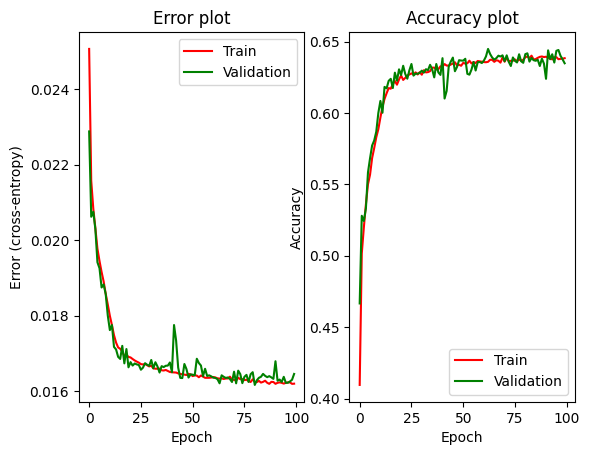

Test accuracy : 0.6355


In [19]:
dict_test_accs = {}
idx1 = 5
idx2 = 2
from tiny_model import NetDiscrete
model = NetDiscrete(4,4,20,idx1,idx2).cuda()
optimizer = torch.optim.SGD(model.parameters(),lr=0.1)
criterion = nn.CrossEntropyLoss()
batch_size = 64
train_errors = []
train_acc = []
val_errors = []
val_acc = []
n_train = len(train_loader)*batch_size
n_val = len(val_loader)*batch_size
for i in range(100):
    total_loss = 0
    total_acc = 0
    c = 0
    for (images,labels) in train_loader:
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
        total_acc+=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0    
        c+=1
        #validation
        total_loss_val = 0
        total_acc_val = 0
        c = 0
    for images,labels in val_loader:
        images = images.cuda()
        labels = labels.cuda()
        output = model(images)
        loss = criterion(output,labels)
        total_loss_val +=loss.item()
        total_acc_val +=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0
        c+=1
    train_errors.append(total_loss/n_train)
    train_acc.append(total_acc/n_train)
    val_errors.append(total_loss_val/n_val)
    val_acc.append(total_acc_val/n_val)
    print("Train acc",train_acc[-1])
    print("Val acc",val_acc[-1])
print("Training complete")
print(idx1,idx2)
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(train_errors, 'r',label="Train")
ax[0].plot(val_errors, 'g', label="Validation")
ax[0].set_title("Error plot")
ax[0].set_ylabel("Error (cross-entropy)")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[1].plot(train_acc, 'r',label="Train")
ax[1].plot(val_acc, 'g', label="Validation")
ax[1].set_title("Accuracy plot")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].legend()
plt.show()
total_acc = 0
for images,labels in test_loader:
    images = images.cuda()
    labels = labels.cuda()
    output = model(images)
    total_acc+=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0
print("Test accuracy :",total_acc/len(test_loader.dataset))
test_acc = total_acc/len(test_loader.dataset)
dict_test_accs[(idx1,idx2)]= test_acc